In [135]:
import MeCab
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.common import flatten
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from gensim.models import KeyedVectors
from gensim.models.word2vec import Word2Vec
from xgboost import XGBClassifier
from collections import Counter
from collections import defaultdict

plt.style.use('seaborn-paper')

In [73]:
df = pd.read_csv(
    r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\data\all_20200423.csv")
df = df[["content", "rating"]]
df.columns = ["content", "label"]
df["content"] = df["content"].apply(str)
df["label"] = df["label"].apply(int)
df["label"] = df["label"].map(lambda x: 1 if int(x)>3 else 0)

In [74]:
df

content  label
0      アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...      0
1                                                    nan      1
2      ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...      1
3      広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...      1
4      音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...      0
...                                                  ...    ...
13918                                                 最高      1
13919                                               サイコー      1
13920                                                 最高      1
13921                                           (  -_・)?      0
13922                                       (｀・∀・)ﾉｲｪ-ｲ！      1

[13923 rows x 2 columns]

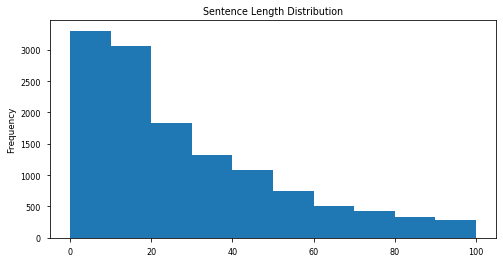

In [76]:
df["length"] = df["content"].map(len)
df["length"].plot(kind="hist", 
                  title="Sentence Length Distribution", 
                  range=(0, 100), 
                  figsize=(8, 4))

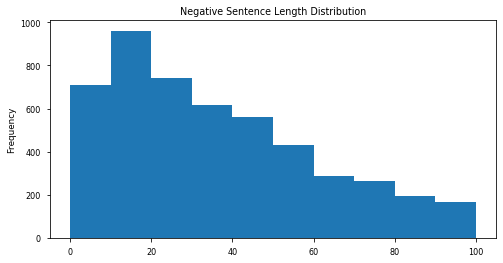

In [77]:
df["length"] = df["content"].map(len)
df[df["label"] == 0]["length"].plot(
    kind="hist", 
    title="Negative Sentence Length Distribution", 
    range=(0, 100), 
    figsize=(8, 4))

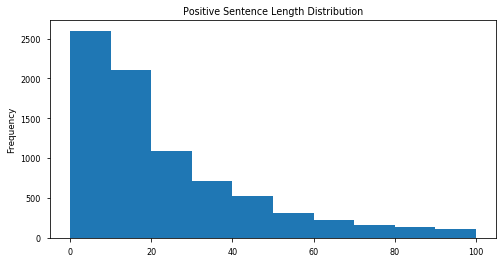

In [78]:
df["length"] = df["content"].map(len)
df[df["label"] == 1]["length"].plot(
    kind="hist", 
    title="Positive Sentence Length Distribution", 
    range=(0, 100), 
    figsize=(8, 4))

In [79]:
Counter(df["label"])

Counter({0: 5587, 1: 8336})

In [80]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.14077   	  55 	    84
 85.21870   	  68 	    46
 90.21044   	  86 	    36
 92.06349   	  96 	    21
 95.07290   	  118 	    14


In [81]:
df = df[df["length"] >= 5]
train, test = train_test_split(df, train_size=0.9, random_state=308)

In [82]:
def create_mecab_list(text):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Ochasen")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

def remove_stopwords(text):
    stopwords = pd.read_csv("C:/Users/YangWang/Desktop/Text_Classifier_for_UtaPass_and_KKBOX/Japanese_stopword_list.txt", 
                    encoding="utf-8", header=None, sep="\n")
    stopwords = list(flatten(stopwords.values.tolist()))
    filtered_words = [word for word in text if word not in stopwords]
    return "".join(filtered_words)

def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ''.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    text = remove_stopwords(text)
    text = give_emoji_free_text(text)
    text_list = create_mecab_list(text)
    return text_list

In [117]:
class Word2VecVectorizer:
    def __init__(self):
        # Load in pretrained word vectors from https://github.com/Kyubyong/wordvectors
        print("Loading in word vectors...")
        self.w2v = Word2Vec.load(
            r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\word2vec\ja.bin")
        self.word2vec = {w: vec for w, vec in zip(w2v.wv.index2word, w2v.wv.vectors)}
        print("Finished loading in word vectors.")
        
    def fit(self, data):
        pass
    
    def transform(self, data):
        # Dimension of feature
        self.D = self.w2v.wv.vector_size
        
        # Convert sentences using bag of word
        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            # First, remove stopwords and emoji. Second, tokenise sentence using mecab.
            tokens = clean_text(sentence)
            vecs = []
            m = 0
            for word in tokens:
                try: 
                    vec = self.w2v.wv.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [139]:
# Reference from https://www.kaggle.com/mohanamurali/bgow-tf-idf-lr-w2v-lgb-bayesopt
class TfidfWord2VecVectorizer:
    def __init__(self):
        # Load in pretrained word vectors from https://github.com/Kyubyong/wordvectors
        print("Loading in word vectors...")
        self.w2v = Word2Vec.load(
            r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\word2vec\ja.bin")
        self.word2vec = {w: vec for w, vec in zip(w2v.wv.index2word, w2v.wv.vectors)}
        self.word2weight = None
        self.dim = self.w2v.wv.vector_size
        print("Finished loading in word vectors.")
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [143]:
vectorizer = TfidfWord2VecVectorizer()
vectorizer.fit(train["content"], train.label)

x_train = vectorizer.transform(train.content)
y_train = train.label

x_test = vectorizer.transform(test.content)
y_test = test.label

Loading in word vectors...
Finished loading in word vectors.


In [144]:
print("# of training data: {}\n# of features: {}".format(x_train.shape[0], x_train.shape[1]))
x_train

# of training data: 11601
# of features: 300


array([[ 3.11301756,  2.35596228, -2.68060398, ...,  2.26685715,
         3.41363645,  5.11368418],
       [-1.30538476,  2.3893075 , -0.58033049, ...,  1.17891562,
         1.8993299 , -0.03156853],
       [ 0.13560088,  0.60168827,  0.04514949, ...,  1.62415779,
         0.48791775, -1.88457346],
       ...,
       [-0.80822146,  1.71746981,  0.10831501, ...,  0.34115592,
         2.04096341,  3.12248945],
       [-0.78747952,  1.9783287 ,  0.99561584, ...,  0.98709571,
         0.20164378, -0.39591172],
       [-1.18944037,  2.40101743,  2.188833  , ..., -0.57516944,
         1.67473328,  0.1179464 ]])

In [118]:
vectorizer = Word2VecVectorizer()

x_train = vectorizer.fit_transform(train.content)
y_train = train.label

x_test = vectorizer.fit_transform(test.content)
y_test = test.label

Loading in word vectors...
Finished loading in word vectors.
Number of samples with no words found: 2968 / 11601
Number of samples with no words found: 333 / 1289


In [134]:
w2v = Word2Vec.load(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\word2vec\ja.bin")
word2vec = {w: vec for w, vec in zip(w2v.wv.index2word, w2v.wv.vectors)}
word2vec

{'の': array([-0.5994279 ,  0.89275813, -1.3500179 ,  1.1442318 ,  0.41814762,
        -0.629241  ,  0.56318384, -0.268145  ,  0.74478924,  0.06280211,
        -0.68440104,  0.5039043 ,  0.86023813,  0.8222944 , -0.22300546,
         0.7700216 ,  0.36964938,  0.29811472,  0.70310605, -0.2008642 ,
         0.07087748, -0.4697804 ,  0.70631605,  0.61496943, -0.7668651 ,
         1.0046805 ,  0.66606176, -0.21515279,  0.7455961 , -1.7472606 ,
        -1.8999013 ,  0.14235918, -2.011021  ,  0.92132616,  1.2876211 ,
         0.34154063, -0.6726943 ,  0.94077665, -0.29111108,  0.18492144,
         0.2587782 ,  1.1679916 , -0.35247782,  0.620738  ,  0.5772139 ,
        -0.10543845,  0.7565549 , -0.3290866 ,  0.5977534 ,  0.3998104 ,
        -0.22729397,  0.30069235,  1.390275  , -0.6260021 ,  0.5082663 ,
         0.4247363 , -0.27633014,  0.19176175,  0.32789895,  0.752108  ,
        -0.41039592,  0.21454856, -0.1302497 ,  1.0235561 , -0.05073407,
        -0.6170539 ,  0.40737098,  0.18339767,

In [119]:
print("# of training data: {}\n# of features: {}".format(x_train.shape[0], x_train.shape[1]))
x_train

# of training data: 11601
# of features: 300


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.98223037, -0.06015475,  0.21150804, ...,  0.66630161,
         0.36338922, -0.19492108],
       [-0.87418514,  0.14833479, -0.28054249, ..., -1.18489623,
         0.17160192, -0.40226942],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10939612, -0.54686445,  0.23615688, ...,  0.49457023,
         0.50383806,  0.62354094],
       [-2.44564557, -0.98743474, -1.08631861, ...,  0.8846404 ,
         0.26433957, -0.97024173]])

In [87]:
def performance(model, x_train, y_train, x_test, y_test):
    print("train score: ", round(model.score(x_train, y_train), 4))
    print("test score: ", round(model.score(x_test, y_test), 4))
    print("f-beta score: ", round(f1_score(y_test, model.predict(x_test)), 4))
    print("roc auc score: ", round(roc_auc_score(y_test, model.predict(x_test)), 4))
    print("confusion matrix: \n", confusion_matrix(y_test, model.predict(x_test)))

In [114]:
knn_model = KNeighborsClassifier(
    n_neighbors=10)
knn_model.fit(x_train, y_train)
performance(knn_model, x_train, y_train, x_test, y_test)

train score:  0.7512
test score:  0.7246
f-beta score:  0.7632
roc auc score:  0.7158
confusion matrix: 
 [[362 192]
 [163 572]]


In [115]:
rfc_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=17)
rfc_model.fit(x_train, y_train)
performance(rfc_model, x_train, y_train, x_test, y_test)

train score:  0.9486
test score:  0.7362
f-beta score:  0.7778
roc auc score:  0.7243
confusion matrix: 
 [[354 200]
 [140 595]]


In [ ]:
xgb_model = XGBClassifier(
    learning_rate=0.01, 
    n_estimators=500, 
    max_depth=10, 
    min_child_weight = 1, 
    gamma=0., 
    subsample=1, 
    colsample_btree=1, 
    scale_pos_weight=1, 
    random_state=17, 
    n_jobs=4, 
    slient=0)
xgb_model.fit(x_train, y_train)
performance(xgb_model, x_train, y_train, x_test, y_test)

In [121]:
xgb = XGBClassifier(
    learning_rate=0.02,  
    n_estimators=500, 
    random_state=17, 
    slient = 0)

params = { 
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=17)

random_search = RandomizedSearchCV(
    xgb, 
    param_distributions=params, 
    n_iter=param_comb, 
    scoring='roc_auc', 
    n_jobs=4, 
    cv=skf.split(x_train, y_train), 
    verbose=2, 
    random_state=17)
random_search.fit(x_train, y_train)
performance(random_search, x_train, y_train, x_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  8.4min finished


train score:  0.9258
test score:  0.7818
f-beta score:  0.7846
roc auc score:  0.7306
confusion matrix: 
 [[355 199]
 [132 603]]


In [93]:
print('Best estimator: \n')
print(random_search.best_estimator_)
print('\n Best hyperparameters: \n')
print(random_search.best_params_)

Best estimator: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=2,
              learning_rate=0.02, max_delta_step=0, max_depth=15,
              min_child_weight=10, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slient=0, subsample=0.8, verbosity=1)

 Best hyperparameters: 

{'subsample': 0.8, 'min_child_weight': 10, 'max_depth': 15, 'gamma': 2, 'colsample_bytree': 0.8}


In [17]:
xgb = XGBClassifier(
    learning_rate=0.02, 
    n_estimators=500, 
    random_state=17, 
    slient = 0)

params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [5, 10, 15, 20]
}
gsearch = GridSearchCV(
    xgb, 
    param_grid=params, 
    scoring='f1', 
    cv=3, 
    n_jobs=4)
gsearch.fit(x_train, y_train)
performance(random_search, x_train, y_train, x_test, y_test)

train score:  0.9661
test score:  0.767
f-beta score:  0.6111
roc auc score:  0.6793
confusion matrix: 
 [[125  41]
 [ 43  66]]


In [18]:
print('Best estimator: \n')
print(gsearch.best_estimator_)
print('\n Best hyperparameters: \n')
print(gsearch.best_estimator_.get_params())

Best estimator: 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.02, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=2000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, slient=0, subsample=0.6, verbosity=1)

 Best hyperparameters: 

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.02, 'max_delta_step': 0, 'max_depth': 10, 'min_child_weight': 10, 'missing': None, 'n_estimators': 2000, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 17, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.6, 'verbosity': 1, 'slient': 0}


In [103]:
etc_model = ExtraTreesClassifier(
    n_estimators=200,
    criterion='gini', 
    random_state=17)
etc_model.fit(x_train, y_train)
performance(etc_model, x_train, y_train, x_test, y_test)

train score:  0.8873
test score:  0.73
f-beta score:  0.7671
roc auc score:  0.7219
confusion matrix: 
 [[368 186]
 [162 573]]


In [104]:
dtc_model = DecisionTreeClassifier(
    max_depth=5, 
    criterion='gini', 
    random_state=17)
dtc_model.fit(x_train, y_train)
performance(dtc_model, x_train, y_train, x_test, y_test)

train score:  0.7288
test score:  0.6936
f-beta score:  0.7354
roc auc score:  0.6848
confusion matrix: 
 [[345 209]
 [186 549]]


In [21]:
eclf = VotingClassifier(
    estimators=[('rfc', rfc_model), ('xgb', xgb_model), ('etc', etc_model), ('dtc', dtc_model)],
    voting='soft')
eclf.fit(x_train, y_train)
performance(eclf, x_train, y_train, x_test, y_test)

train score:  0.9043
test score:  0.6982
f-beta score:  0.5951
roc auc score:  0.6744
confusion matrix: 
 [[131  35]
 [ 48  61]]
